In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
""" This code generates a test set based on 25% of the data, and chooses the rows to eliminate randomly to avoid bias. """
# Data load
df = pd.read_csv('apartments.csv')

# Shuffle data
df = df.sample(frac=1).reset_index(drop=True)

# Calc rows for test set (25%) and validation set (15%)
test_size = int(len(df) * 0.25)
validation_size = int(len(df) * 0.15)

# Calc starting index for validation set
validation_start_index = len(df) - test_size - validation_size

# Split data
test_data = df[-test_size:]
validation_data = df[validation_start_index:-test_size]
train_data = df[:validation_start_index]

# Save to new CSVs
test_data.to_csv('test_data.csv', index=False)
train_data.to_csv('train_data.csv', index=False)
validation_data.to_csv('validation_data.csv', index=False)

In [75]:
def clean_data(train_data, test_data, validation_data):
    # Remove unnecessary columns
    columns_to_drop = ['id','category', 'title', 'body', 'currency', 'fee', 'has_photo', 'price_display', 'address', 'latitude', 'longitude', 'source', 'time']
    train_data.drop(columns=columns_to_drop, inplace=True)
    test_data.drop(columns=columns_to_drop, inplace=True)
    validation_data.drop(columns=columns_to_drop, inplace=True)
    
    # Remove nulls from critical fields
    critical_fields = ['price', 'pets_allowed', 'bedrooms', 'square_feet', 'bathrooms']
    train_data.dropna(subset=critical_fields, inplace=True)
    test_data.dropna(subset=critical_fields, inplace=True)
    validation_data.dropna(subset=critical_fields, inplace=True)
    
    # Remove non-monthly rents
    train_data = train_data[train_data['price_type'] == 'Monthly']
    test_data = test_data[test_data['price_type'] == 'Monthly']
    validation_data = validation_data[validation_data['price_type'] == 'Monthly']
    
    # Make bathroom data boolean
    def replace_bathroom_values(df):
        df['bathrooms'] = df['bathrooms'].apply(lambda x: 0 if x in ['1', '2', '3', 1, 2, 3] else (1 if x in ['4', '5', '6', '7', '8', '9', 4, 5, 6, 7, 8, 9] else x))
    
    # Clean bathroom data
    def round_down_half_bathrooms(train_data, test_data, validation_data):
        def round_down_half(value):
            # Check if the value ends with .5 and is not NaN
            if not pd.isnull(value) and str(value).endswith('.5'):
                return float(value) - 0.5
            else:
                return value

        # Apply the transformation to the 'bathrooms' column of each DataFrame
        for df in [train_data, test_data, validation_data]:
            df['bathrooms'] = df['bathrooms'].apply(round_down_half)
    
    # Make bedroom data boolean
    def replace_bedroom_values(df):
        df['bedrooms'] = df['bedrooms'].apply(lambda x: 0 if x in ['1', '1.5' '2', '2.5', '3', 1, 1.5, 2, 2.5, 3] else (1 if x in ['4', '4.5', '5', '5.5', '6', '6.5', '7', '7.5', '8', '8.5' '9', 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9] else x))
    
    # Calc average sqft
    total_square_feet = pd.concat([train_data['square_feet'], test_data['square_feet'], validation_data['square_feet']], ignore_index=True)
    average_square_feet = total_square_feet.astype(float).mean()
    
    # Make amenities boolean
    def assign_amenities_value(train_data, test_data, validation_data):
        for df in [train_data, test_data, validation_data]:
            # Assigns 0 if 'amenities' is null, and 1 otherwise
            df['amenities'] = np.where(df['amenities'].isnull(), 0, 1)
    
    # Make sqft data boolean
    def convert_sqft_to_boolean(df, average_sqft):
        df['square_feet'] = df['square_feet'].apply(lambda x: 0 if pd.isna(x) or float(x) < average_sqft else 1)
    
    # Change pets data to be usable
    def replace_pets_field(train_data, test_data, validation_data):
        # Specify the value to be replaced and the new value
        old_value = "Cats,Dogs"
        new_value = "Cats/Dogs"
    
        # Replace the values in the 'pets' column of each DataFrame
        train_data['pets_allowed'] = train_data['pets_allowed'].replace(old_value, new_value)
        test_data['pets_allowed'] = test_data['pets_allowed'].replace(old_value, new_value)
        validation_data['pets_allowed'] = validation_data['pets_allowed'].replace(old_value, new_value)
    
    replace_pets_field(train_data, test_data, validation_data)
    
    # Make pet data boolean
    def replace_pets_values(df):
        df['pets_allowed'] = df['pets_allowed'].apply(lambda x: 0 if x in ['None'] else (1 if x in ['Cats/Dogs', 'Cats', 'Dogs'] else x))
    
    # Make rent bool
    def assign_rent_boolean(train_data, test_data, validation_data):
        # Concatenate rent prices across all datasets to calculate the overall average
        total_rent = pd.concat([train_data['price'], test_data['price'], validation_data['price']], ignore_index=True)
        average_rent = total_rent.astype(float).mean()

        # Define a transformation function
        def rent_to_boolean(value, average_rent):
            value = float(value)
            return 0 if value < average_rent else 1

        # Apply the transformation to each dataset
        for df in [train_data, test_data, validation_data]:
            df['price'] = df['price'].apply(lambda x: rent_to_boolean(x, average_rent))

    # Apply all functions
    round_down_half_bathrooms(train_data, test_data, validation_data)
    
    convert_sqft_to_boolean(train_data, average_square_feet)
    convert_sqft_to_boolean(test_data, average_square_feet)
    convert_sqft_to_boolean(validation_data, average_square_feet)

    replace_bathroom_values(train_data)
    replace_bathroom_values(test_data)
    replace_bathroom_values(validation_data)

    replace_bedroom_values(train_data)
    replace_bedroom_values(test_data)
    replace_bedroom_values(validation_data)

    replace_pets_values(train_data)
    replace_pets_values(test_data)
    replace_pets_values(validation_data)

    assign_rent_boolean(train_data, test_data, validation_data)
    
    assign_amenities_value(train_data, test_data, validation_data)
    
    train_data.to_csv('cleaned_train_data.csv', index=False)
    test_data.to_csv('cleaned_test_data.csv', index=False)
    validation_data.to_csv('cleaned_validation_data.csv', index=False)

In [76]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
validation_data = pd.read_csv('validation_data.csv')
cleaned_train_data = pd.read_csv('cleaned_train_data.csv')
cleaned_test_data = pd.read_csv('cleaned_test_data.csv')
cleaned_validation_data = pd.read_csv('cleaned_validation_data.csv')

In [77]:
clean_data(train_data, test_data, validation_data)

/var/folders/d7/j1sp4_m13vv9vcx6b6ylj9k40000gn/T/ipykernel_6777/3018385603.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['pets_allowed'] = validation_data['pets_allowed'].replace(old_value, new_value)
/var/folders/d7/j1sp4_m13vv9vcx6b6ylj9k40000gn/T/ipykernel_6777/3018385603.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bathrooms'] = df['bathrooms'].apply(round_down_half)
/var/folders/d7/j1sp4_m13vv9vcx6b6ylj9k40000gn/T/ipykernel_6777/3018385603.py:52: SettingWithCopyWarnin

In [78]:
def plot_numeric_feature_correlation(cleaned_train_data):
    # First, pare down data to only include numerical values
    numeric_values = cleaned_train_data.select_dtypes(include=[int,float])

    # Then, find the corr of the numeric data
    corr = numeric_values.corr()

    # Second, init the figure from plt
    fig_corr = plt.subplots(figsize = (11, 9))

    # And create a heatmap
    cmap = sns.color_palette("Set2", as_cmap=True)

    # Draw it!
    sns.heatmap(corr, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5}, annot=True)

    # Add title and show
    plt.title('Correlation between different features')
    plt.show()


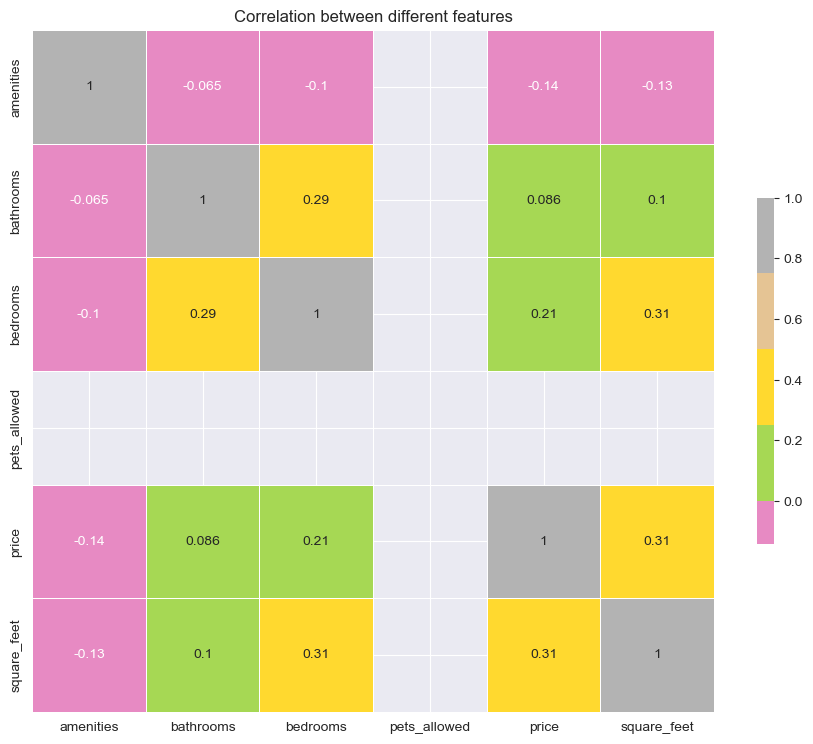

In [79]:
# plot_numeric_feature_correlation(cleaned_train_data)

In [80]:
def plot_histogram(cleaned_train_data, price_column='price'):

    # Let's list all the columns the plot against income
    columns_to_plot = ['amenities', 'bathrooms', 'bedrooms', 'pets_allowed', 'square_feet']

    # Need to calculate how big this should be given the number of columns
    n_rows = len(columns_to_plot) // 2 + len(columns_to_plot) % 2

    # Create figure for all plots
    fig = plt.figure(figsize=(15, 5*n_rows))

    # Iterate and plot each column
    for i, column in enumerate(columns_to_plot, 1):
        plt.subplot(n_rows, 2, i)
        # Intelligently choose plot type based on data type
        if cleaned_train_data[column].dtype in [int, float]:
            # If numerical, use histplot
            sns.histplot(data=cleaned_train_data,x=column,hue=price_column, multiple='dodge', palette='tab10')
        else:
            # Use countplot
            sns.countplot(x=column,data=cleaned_train_data,hue=price_column, palette='tab10')

        plt.xticks(rotation=45, ha='right')
        plt.title(f'Count of {column} by Price')
        fig.set_tight_layout(True)

    plt.show()
    fig.savefig('histogram.pdf')

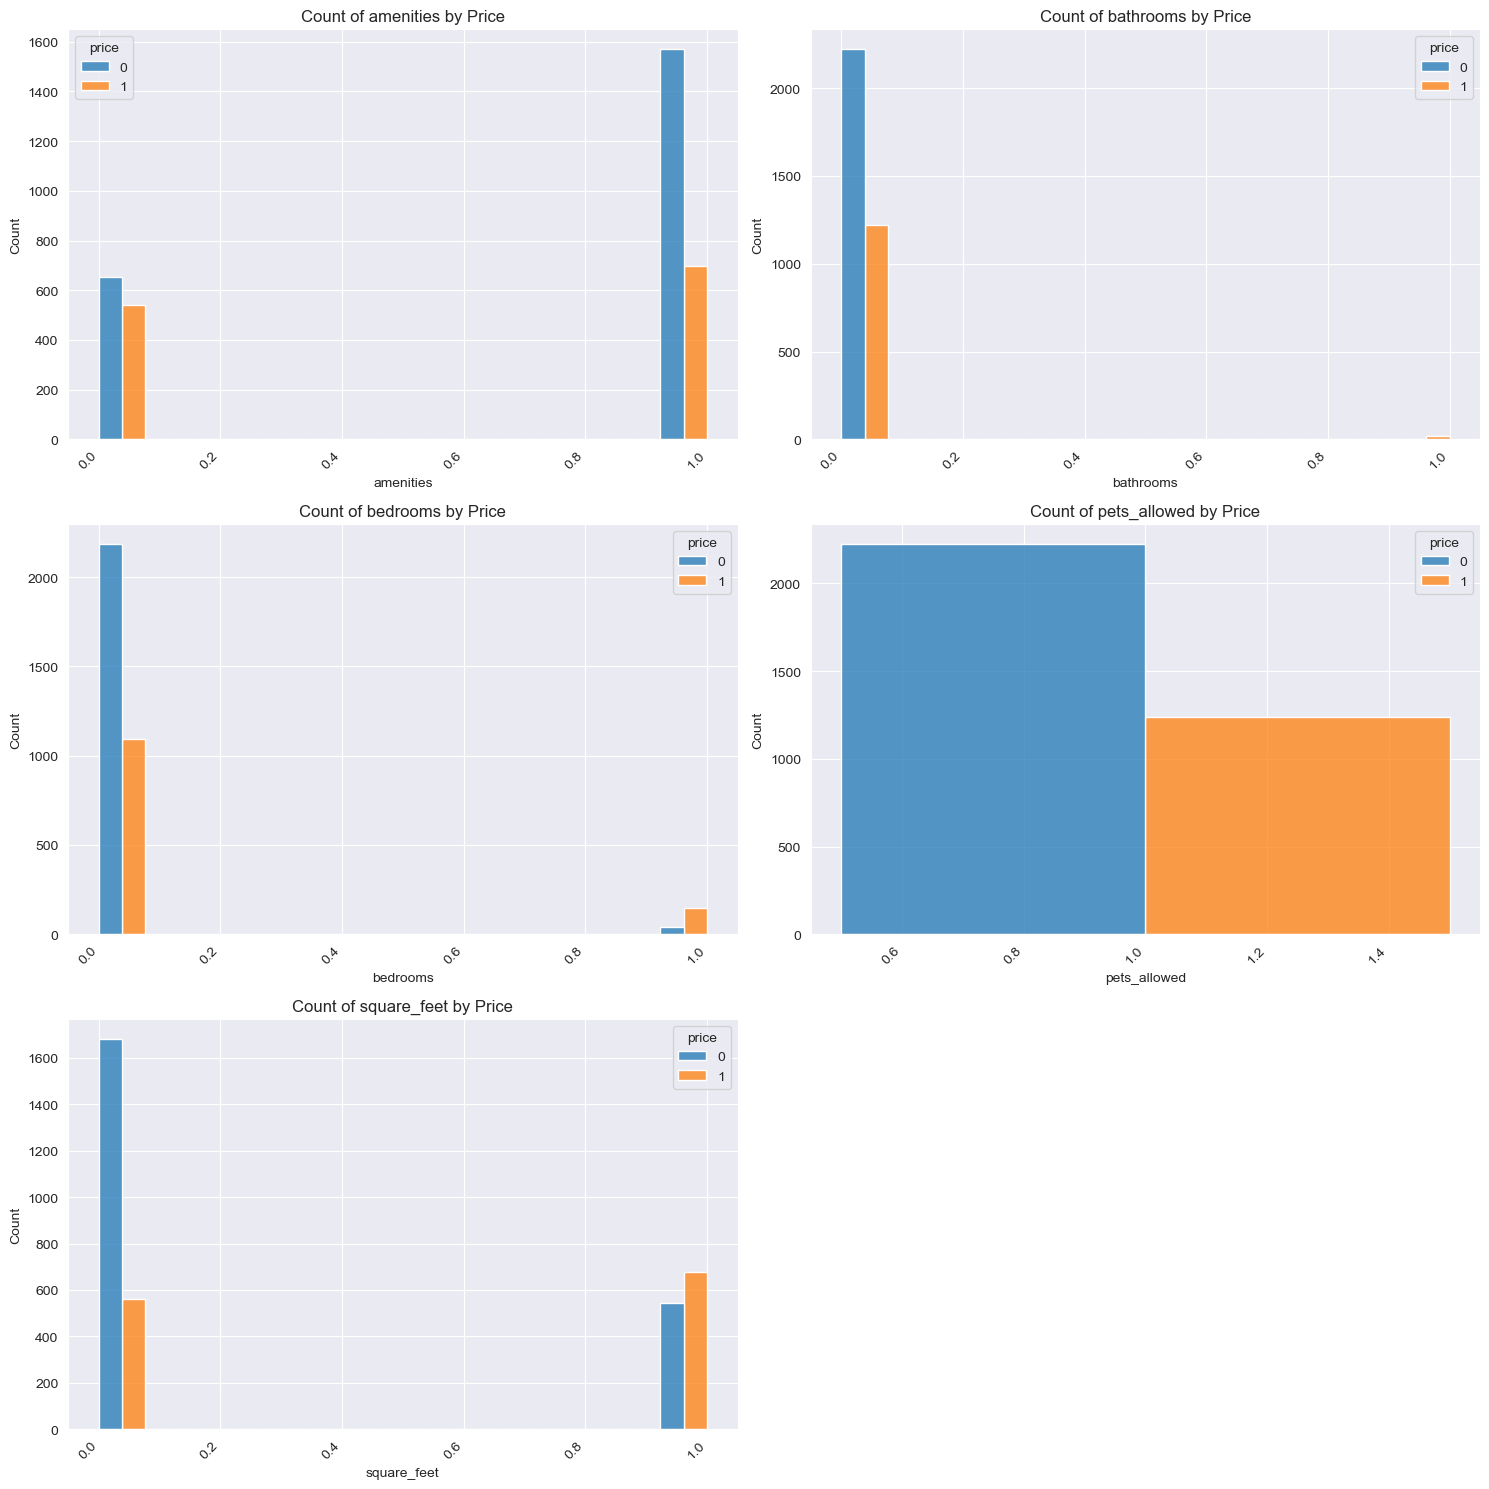

In [81]:
# plot_histogram(cleaned_train_data)